# Marketing Channel Effectiveness Analysis 
- Submitted By: Shashi Sharma
- email: ss139529@gmail.com

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pymc_marketing.metrics import crps
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.utils import apply_sklearn_transformer_across_dim
from pymc_marketing.prior import Prior

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 4]
plt.rcParams["figure.dpi"] = 100

In [3]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [4]:
data_df = pd.read_csv("https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv")

# Converting Date column to datetime format
data_df["Date"] = pd.to_datetime(data_df["Date"])

# Adding a new column "t" starting from 1
data_df = data_df.sort_values(by="Date").reset_index(drop=True)
data_df["t"] = range(1, len(data_df) + 1)

# Define column names
date_column = "Date"
channel_columns = sorted(["TV", "Radio", "Banners"]) # 1. Media spend variables
sales_col = "Sales"  # 2. Target variable (KPI)


# Printing the first few rows to verify
print(data_df.head())

        Date       TV    Radio  Banners     Sales  t
0 2018-01-07  13528.1     0.00     0.00   9779.80  1
1 2018-01-14      0.0  5349.65  2218.93  13245.19  2
2 2018-01-21      0.0  4235.86  2046.96  12022.66  3
3 2018-01-28      0.0  3562.21     0.00   8846.95  4
4 2018-02-04      0.0     0.00  2187.29   9797.07  5


## 1. Exploratory Data Analysis

In [5]:
# Summary of the dataset
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     200 non-null    datetime64[ns]
 1   TV       200 non-null    float64       
 2   Radio    200 non-null    float64       
 3   Banners  200 non-null    float64       
 4   Sales    200 non-null    float64       
 5   t        200 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 9.5 KB


In [6]:
# Checking for duplicate rows
print(f"Duplicate rows: {data_df.duplicated().sum()}")

Duplicate rows: 0


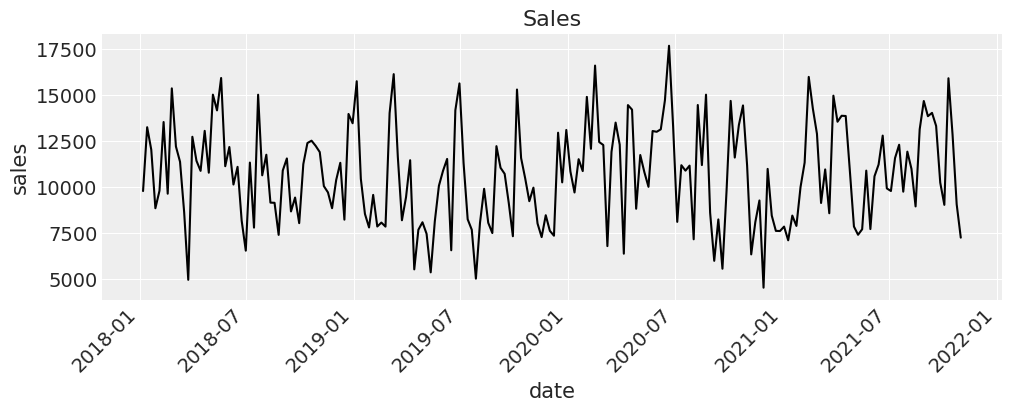

In [7]:
fig, ax = plt.subplots()
sns.lineplot(data=data_df, x=date_column, y=sales_col, color="black", ax=ax)
ax.set(title="Sales", xlabel="date", ylabel="sales")
plt.xticks(rotation=45, ha='right')
plt.show()

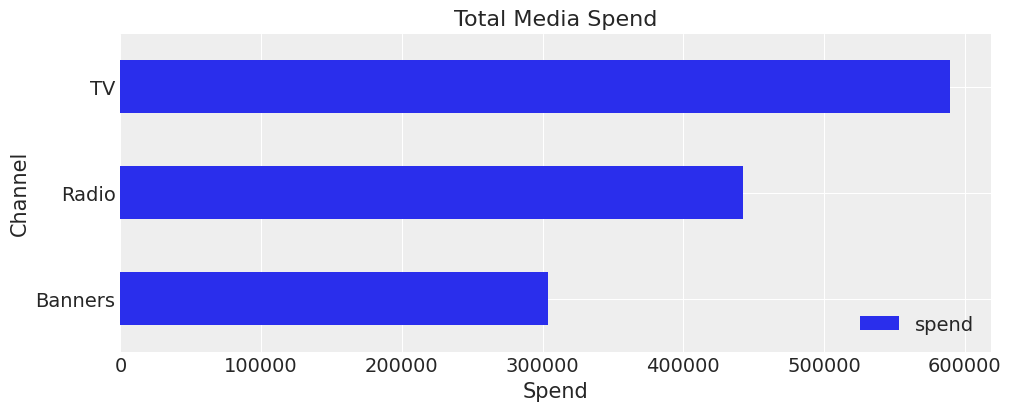

In [8]:
fig, ax = plt.subplots()
data_df.melt(
    value_vars=channel_columns, var_name="channel", value_name="spend"
).groupby("channel").agg({"spend": "sum"}).sort_values(by="spend").plot.barh(ax=ax)
ax.set(title="Total Media Spend", xlabel="Spend", ylabel="Channel")
plt.show()

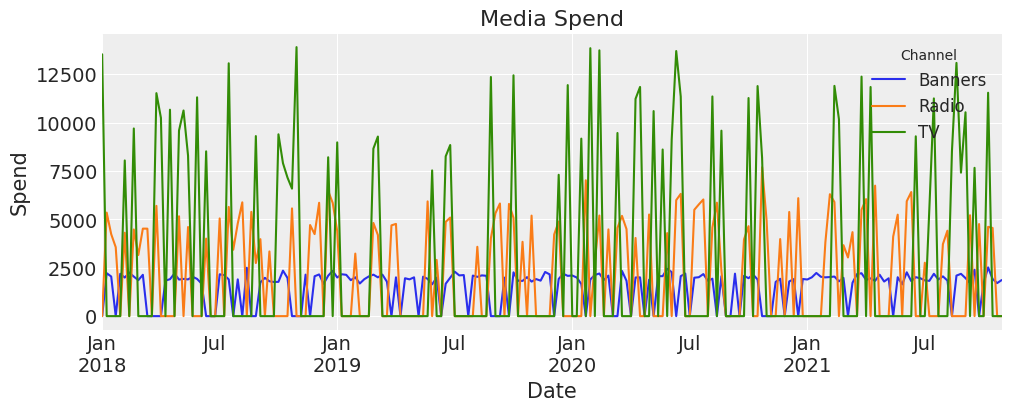

In [9]:
fig, ax = plt.subplots()
data_df.set_index(date_column)[channel_columns].plot(ax=ax)
ax.legend(title="Channel", fontsize=12)
ax.set(title="Media Spend", xlabel="Date", ylabel="Spend")
plt.show()

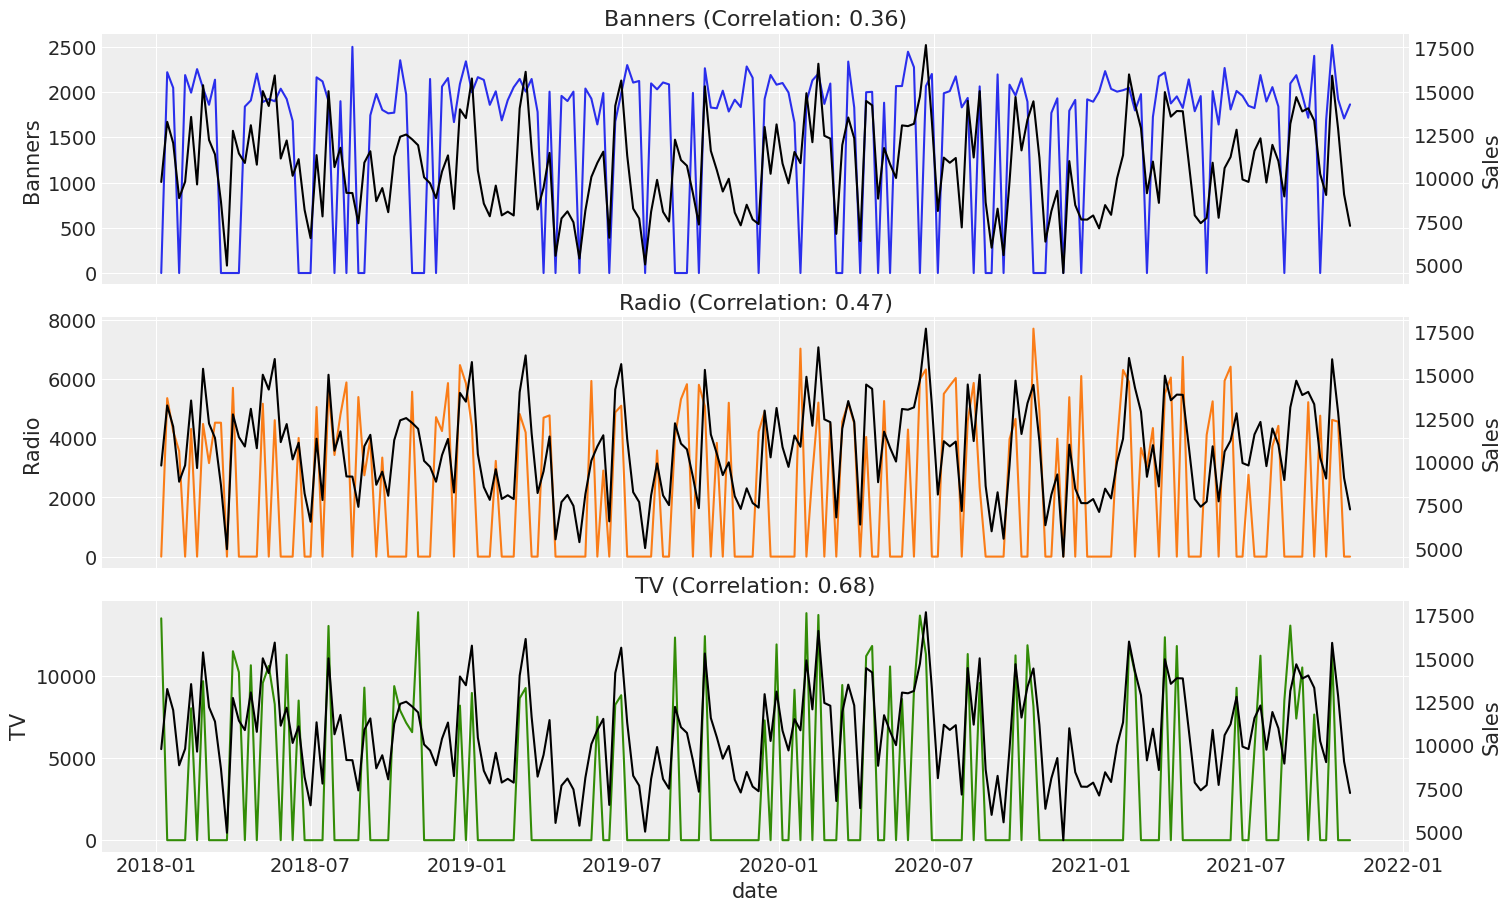

In [10]:
n_channels = len(channel_columns)

fig, axes = plt.subplots(
    nrows=n_channels,
    ncols=1,
    figsize=(15, 3 * n_channels),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for i, channel in enumerate(channel_columns):
    ax = axes[i]
    ax_twin = ax.twinx()
    sns.lineplot(data=data_df, x=date_column, y=channel, color=f"C{i}", ax=ax)
    sns.lineplot(data=data_df, x=date_column, y=sales_col, color="black", ax=ax_twin)
    correlation = data_df[[channel, sales_col]].corr().iloc[0, 1]
    ax_twin.grid(None)
    ax.set(title=f"{channel} (Correlation: {correlation:.2f})")

ax.set_xlabel("date")
plt.show()

- 1. The data is clean.
- 2. A random seasonal pattern is observed.
- 3. TV media has the highest spend and the strongest correlation with sales, meaning higher TV spend is more likely to drive higher sales.

## Train-Test Split

Training set ends on: 2021-01-24 00:00:00
Test set starts on: 2021-01-31 00:00:00


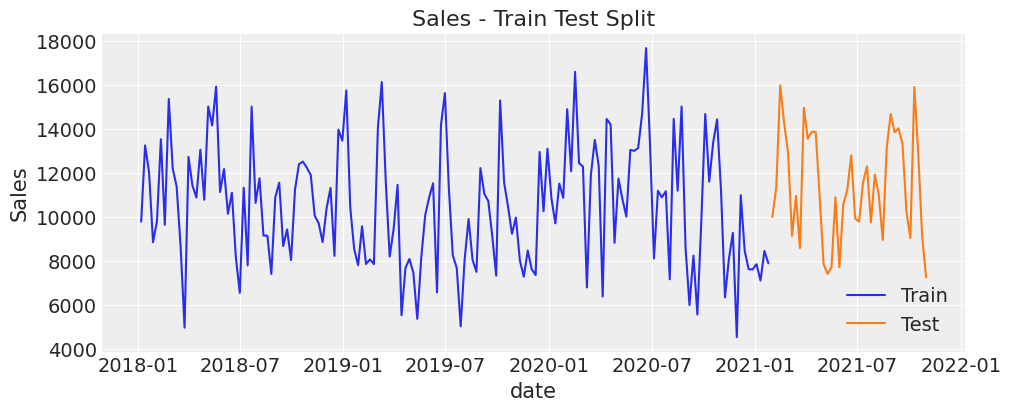

In [11]:
# Define the train-test split point based on "t"
split_point = int(0.8 * len(data_df))  # 80% of the data as train

# Train-test split using "t"
train_df = data_df[data_df["t"] <= split_point]
test_df = data_df[data_df["t"] > split_point]

# Get the last week of train set and first week of test set
train_end_week = train_df["Date"].max()
print(f"Training set ends on: {train_end_week}")

test_start_week = test_df["Date"].min()
print(f"Test set starts on: {test_start_week}")

fig, ax = plt.subplots()
sns.lineplot(data=train_df, x=date_column, y="Sales", color="C0", label="Train", ax=ax)
sns.lineplot(data=test_df, x=date_column, y="Sales", color="C1", label="Test", ax=ax)
ax.set(title="Sales - Train Test Split", xlabel="date")
plt.show()

In [12]:
X_train = train_df.drop(columns=[sales_col, 't'])
X_test = test_df.drop(columns=[sales_col, 't'])

y_train = train_df[sales_col]
y_test = test_df[sales_col]

## 2. Think of alignment of Spendings and Sales:

In [13]:
spend_shares = (
    X_train.melt(value_vars=channel_columns, var_name="channel", value_name="spend")
    .groupby("channel", as_index=False)
    .agg({"spend": "sum"})
    .sort_values(by="channel")
    .assign(spend_share=lambda x: x["spend"] / x["spend"].sum())["spend_share"]
    .to_numpy()
)

prior_sigma = spend_shares
prior_sigma

array([0.2249355 , 0.33330676, 0.44175775])

#### Prior Analysis:

- Marketing activities have delayed effects on sales, making time lag analysis essential; it is defined using the Adstock transformation.
- Correlation alone is insufficient to determine time lag; historical data is also required.
- Assuming time lags: TV = 4, Radio = 2, Banner = 1, while setting 𝑙_max=6 to allow the model to learn the optimal lag.
- Setting a reasonable baseline for sales using an intercept (𝜇=0.2, σ=0.05).

We will discuss more about priors while configuring the model

## 3.  Build Impact Identification Model: 

In [15]:
model_config = {
    "intercept": Prior("Normal", mu=0.2, sigma=0.05),
    "saturation_beta": Prior("HalfNormal", sigma=prior_sigma, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=3, beta=1, dims="channel"),
    "gamma_control": Prior("Normal", mu=0, sigma=1),
    "gamma_fourier": Prior("Laplace", mu=0, b=1),
    "likelihood": Prior("TruncatedNormal", lower=0, sigma=Prior("HalfNormal", sigma=1)),
}

- Specifies prior distributions for different model parameters (**intercept, saturation, seasonality, and likelihood**).
- **"intercept"**: `Prior("Normal", mu=0.2, sigma=0.05)`    
    - The intercept represents the baseline sales without any marketing spend.  
    - The mean (𝜇=0.2, 𝜎 = 0.05) ensures a reasonable baseline sales level, reflecting a stable business, that sales come from media and organic as well
    - Higher 𝜇 is suitable for well-established brands with strong organic demand.

- **"saturation_beta"**: `Prior("HalfNormal", sigma=prior_sigma, dims="channel")`  
  - Saturation = the point where increasing ad spend has little to no additional impact on sales.  
  - prior_sigma (spend_shares) is used so that larger spend channels have higher uncertainty in their β value or saturation effects.
  - High β (slow saturation), and Low β (fast saturation).

- **"saturation_lam"**: `Prior("Gamma", alpha=3, beta=1, dims="channel")` 
  - Saturation lambda (𝜆) in logistic saturation controls how steeply saturation happens—essentially.
  - Higher 𝜆 → Steeper curve → Diminishing returns happen quickly (spend becomes ineffective fast).
  - Lower 𝜆 → Flatter curve → Spend continues to give returns for a longer time before diminishing.
  - Gamma(𝛼=3, 𝛽=1) Balances Between Quick and Slow Saturation, and λ remains Positive due to gamma distribution.

- **"gamma_fourier"**: `Prior("Laplace", mu=0, b=1)`  
  - Handles seasonality effects using Fourier terms.  
  - Laplace (**Sparse Prior**) encourages the model to pick only the most relevant seasonal components.  

- **"likelihood"**: `Prior("TruncatedNormal", lower=0, sigma=Prior("HalfNormal", sigma=1))`  
  - The likelihood function describes how the observed sales data relates to the model's predictions.
  - In Bayesian MMM, we assume that sales follow a probability distribution rather than being a fixed number.
  - Half-Normal Prio used to avoid extream uncertainty


In [ ]:
sampler_config = {"progressbar": True}

mmm = MMM(
    model_config=model_config, # commentout while using default_model_config
    sampler_config=sampler_config,
    adstock=GeometricAdstock(l_max=6),
    saturation=LogisticSaturation(),
    date_column=date_column,
    channel_columns=channel_columns,
    yearly_seasonality=5,
)

- **`adstock = GeometricAdstock(l_max=6)`**  
  - Applies a **geometric adstock transformation**, which models how past marketing spend carries over into future periods.  
  - **`l_max=6`**: Spend effects last up to maximum **6 time steps** (e.g., 6 weeks).  

### Prior Predictive Checks (Ensures the model is reasonable before fitting data.)

Sampling: [adstock_alpha, gamma_fourier, intercept, saturation_beta, saturation_lam, y, y_sigma]


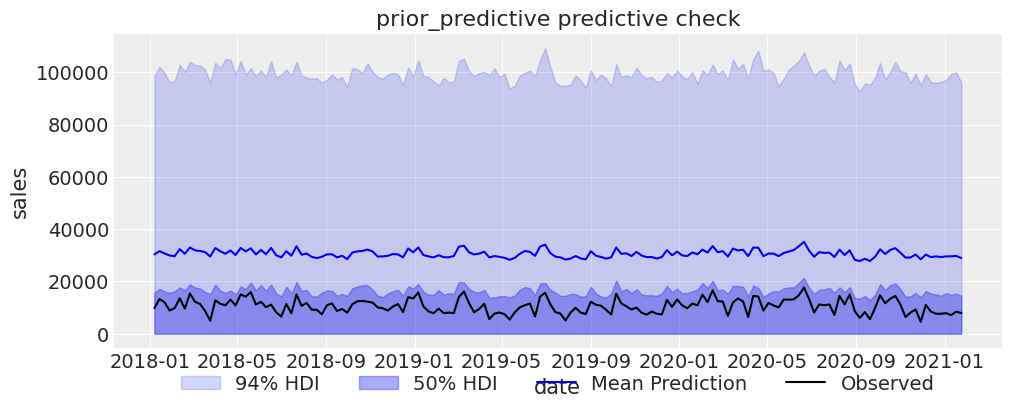

In [17]:
# Generate prior predictive samples
mmm.sample_prior_predictive(X_train, y_train, samples=4000)
fig, ax = plt.subplots()
fig = mmm.plot_prior_predictive(original_scale=True, ax=ax)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4)
ax.set(xlabel="date", ylabel="sales")
plt.show()

- The **observed sales (black line)** falls within the **shaded region**, the **priors are reasonable**.  

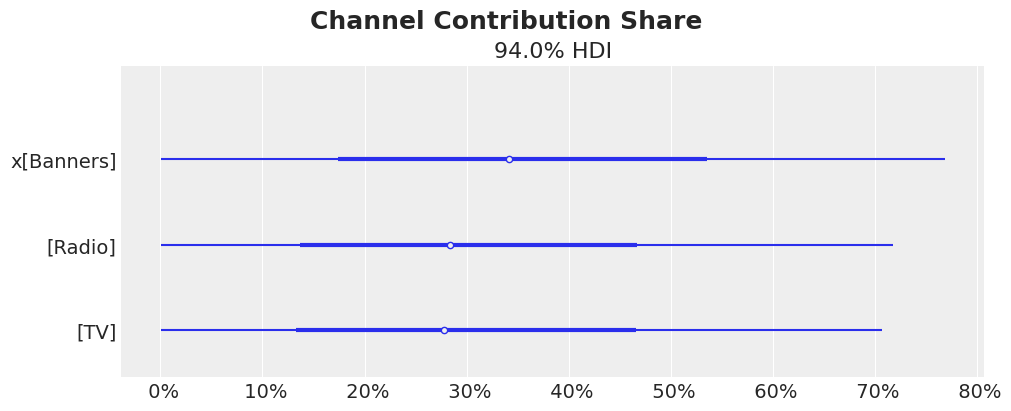

In [18]:
fig = mmm.plot_channel_contribution_share_hdi(prior=True, figsize=(10, 4))
fig.suptitle("Channel Contribution Share", fontsize=18, fontweight="bold")
plt.show()

Represents how much each media channel contributes to total sales based on the prior predictive distribution.

### Model Fitting

In [ ]:
import multiprocessing

if __name__ == "__main__":  # Ensures multiprocessing is handled safely
    multiprocessing.set_start_method("spawn", force=True)

    # Your model training code
    mmm.fit(
        X=X_train,
        y=y_train,
        target_accept=0.9,
        chains=4,  # Multiple chains for better MCMC performance
        draws=1000, # Samples 1,000 posterior values per chain.
        nuts_sampler="pymc",
        random_seed=rng,
    )

Initializing NUTS using jitter+adapt_diag...
/home/mleshashi/MMM/mmm/lib/python3.10/site-packages/pytensor/link/c/cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 217 seconds.


## Model Diagnostics

In [20]:
# Check the contents of the InferenceData object
mmm.idata

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

In [21]:
# Number of diverging samples
mmm.idata["sample_stats"]["diverging"].sum().item()

0

- Divergences indicate instability in MCMC sampling → If too many divergences occur, the posterior estimates may be unreliable.
- Helps detect bad priors or extreme parameter values.

In [22]:
az.summary(
    data=mmm.idata,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_fourier",
    ],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept                 0.275  0.008   0.259    0.291      0.000    0.000   
y_sigma                   0.028  0.002   0.025    0.031      0.000    0.000   
saturation_beta[Banners]  0.262  0.073   0.161    0.397      0.002    0.002   
saturation_beta[Radio]    0.369  0.105   0.219    0.560      0.003    0.003   
saturation_beta[TV]       0.438  0.034   0.377    0.500      0.001    0.001   
saturation_lam[Banners]   1.895  0.666   0.763    3.106      0.014    0.011   
saturation_lam[Radio]     1.823  0.539   0.860    2.827      0.012    0.008   
saturation_lam[TV]        3.293  0.339   2.680    3.964      0.008    0.005   
adstock_alpha[Banners]    0.039  0.028   0.000    0.087      0.001    0.000   
adstock_alpha[Radio]      0.217  0.030   0.157    0.272      0.001    0.001   
adstock_alpha[TV]         0.491  0.018   0.458    0.524      0.000    0.000   
gamma_fourier[sin_1]      0.007  0.003   0.001    0.014      0.000    0.000   
gamma_fourier[sin_2]      0.003  0.003  -0.004    0.009      0.000    0.000   
gamma_fourier[sin_3]      0.002  0.003  -0.004    0.009      0.000    0.000   
gamma_fourier[sin_4]     -0.002  0.003  -0.008    0.004      0.000    0.000   
gamma_fourier[sin_5]      0.003  0.003  -0.003    0.009      0.000    0.000   
gamma_fourier[cos_1]      0.003  0.003  -0.004    0.009      0.000    0.000   
gamma_fourier[cos_2]     -0.003  0.003  -0.009    0.004      0.000    0.000   
gamma_fourier[cos_3]      0.001  0.003  -0.005    0.007      0.000    0.000   
gamma_fourier[cos_4]      0.000  0.003  -0.006    0.006      0.000    0.000   
gamma_fourier[cos_5]     -0.002  0.003  -0.008    0.004      0.000    0.000   

                          ess_bulk  ess_tail  r_hat  
intercept                   2531.0    2115.0   1.00  
y_sigma                     3672.0    3229.0   1.00  
saturation_beta[Banners]    1924.0    1864.0   1.00  
saturation_beta[Radio]      1912.0    1896.0   1.00  
saturation_beta[TV]         1799.0    2043.0   1.00  
saturation_lam[Banners]     1956.0    1873.0   1.00  
saturation_lam[Radio]       1949.0    2041.0   1.00  
saturation_lam[TV]          1879.0    1944.0   1.00  
adstock_alpha[Banners]      1749.0    1431.0   1.01  
adstock_alpha[Radio]        3475.0    2303.0   1.00  
adstock_alpha[TV]           2836.0    2990.0   1.00  
gamma_fourier[sin_1]        3989.0    2918.0   1.00  
gamma_fourier[sin_2]        4419.0    2824.0   1.00  
gamma_fourier[sin_3]        3946.0    3107.0   1.00  
gamma_fourier[sin_4]        3896.0    3284.0   1.00  
gamma_fourier[sin_5]        3859.0    2597.0   1.00  
gamma_fourier[cos_1]        5009.0    3187.0   1.00  
gamma_fourier[cos_2]        4218.0    3329.0   1.00  
gamma_fourier[cos_3]        3482.0    2730.0   1.00  
gamma_fourier[cos_4]        3982.0    2814.0   1.00  
gamma_fourier[cos_5]        3835.0    2834.0   1.00

In [23]:
az.summary(
    data=mmm.idata,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_fourier",
    ],
)["r_hat"].describe()

count    21.000000
mean      1.000476
std       0.002182
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.010000
Name: r_hat, dtype: float64

- Since all R-hat values are close to 1, our MMM model has converged properly!

Text(0.5, 0.98, 'Model Trace')

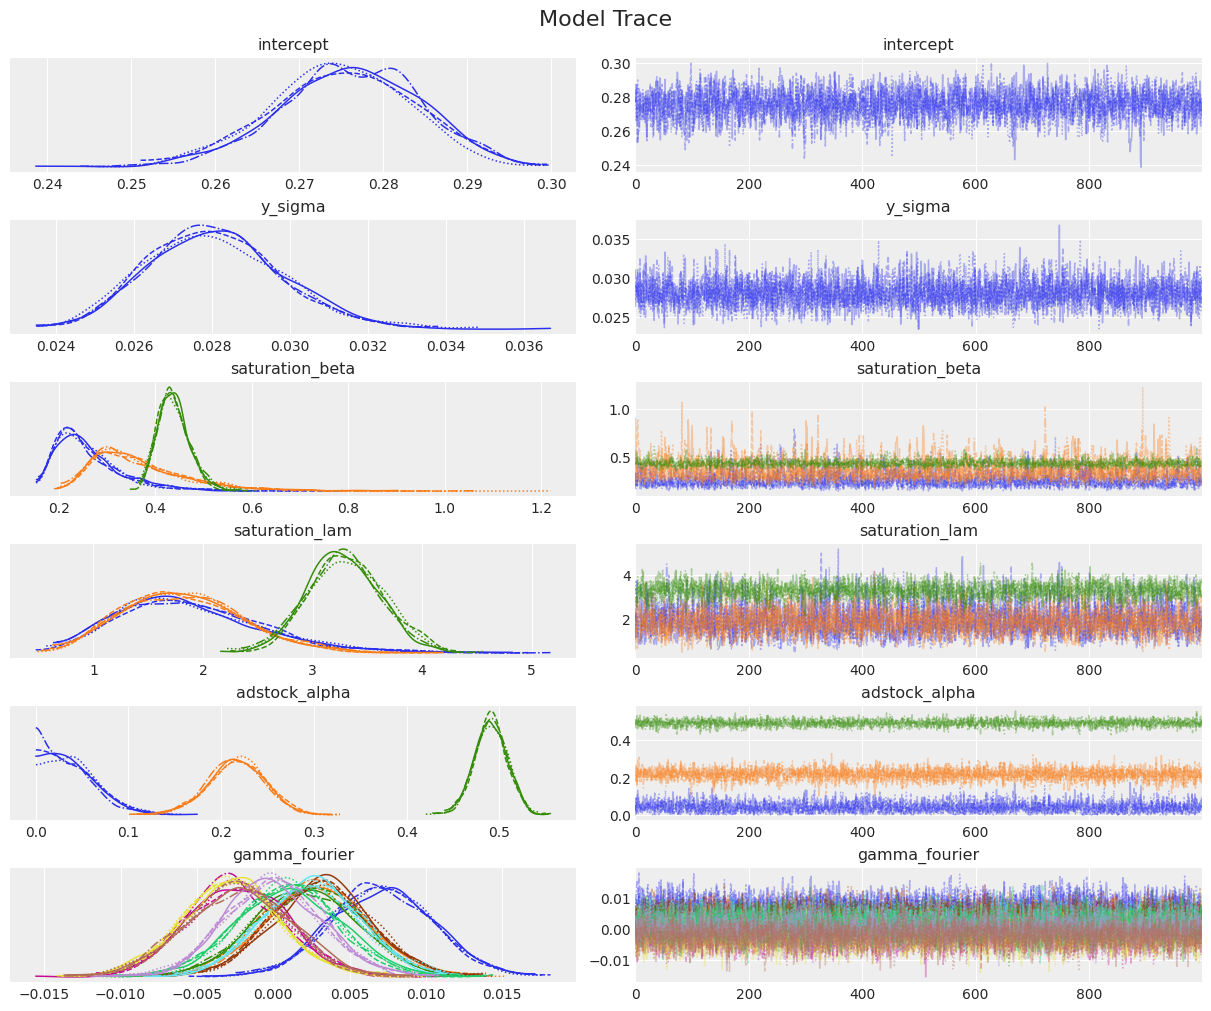

In [24]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_fourier",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16)

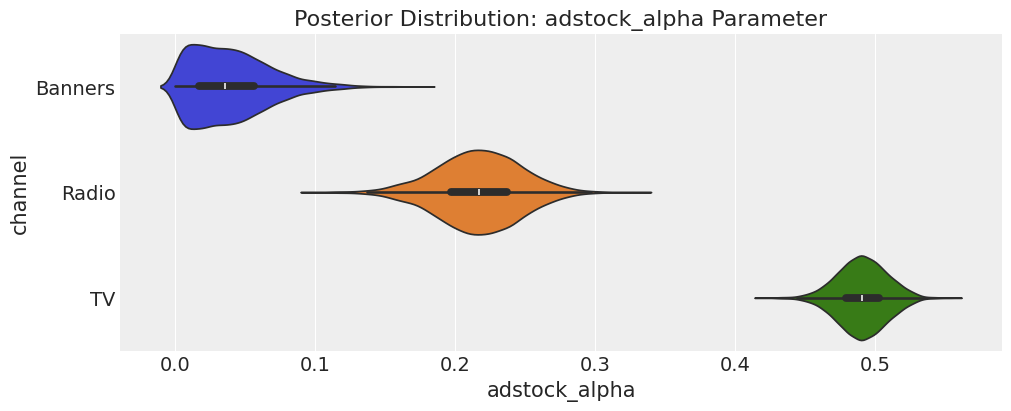

In [25]:
fig = mmm.plot_channel_parameter(param_name="adstock_alpha", figsize=(10, 4))
ax = fig.axes[0]

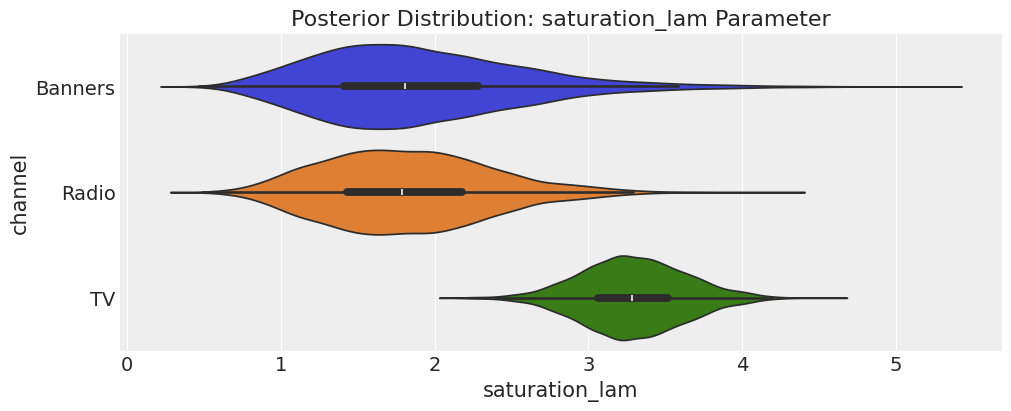

In [26]:
fig = mmm.plot_channel_parameter(param_name="saturation_lam", figsize=(10, 4))
ax = fig.axes[0]

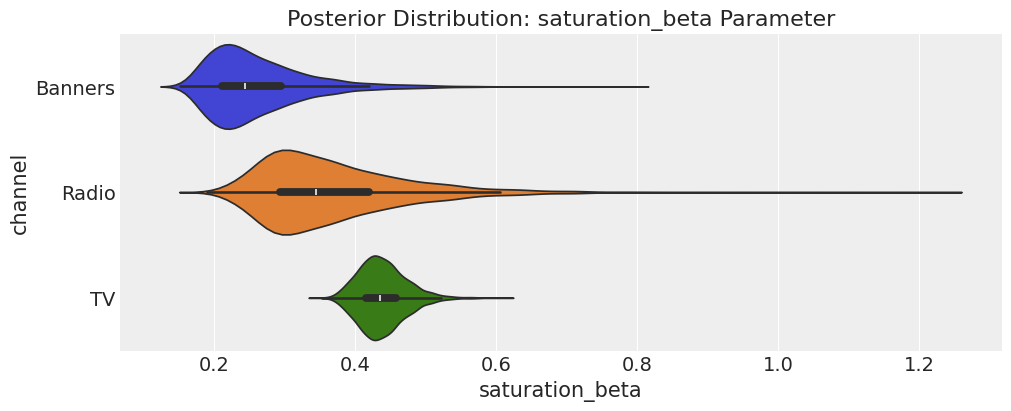

In [27]:
fig = mmm.plot_channel_parameter(param_name="saturation_beta", figsize=(10, 4))
ax = fig.axes[0]

## 4. Decompose Historical Sales: 
A posterior predictive check (PPC) is done to evaluates how well the trained Bayesian MMM model can generate data that resembles the observed historical sales data.

Sampling: [y]


Output()

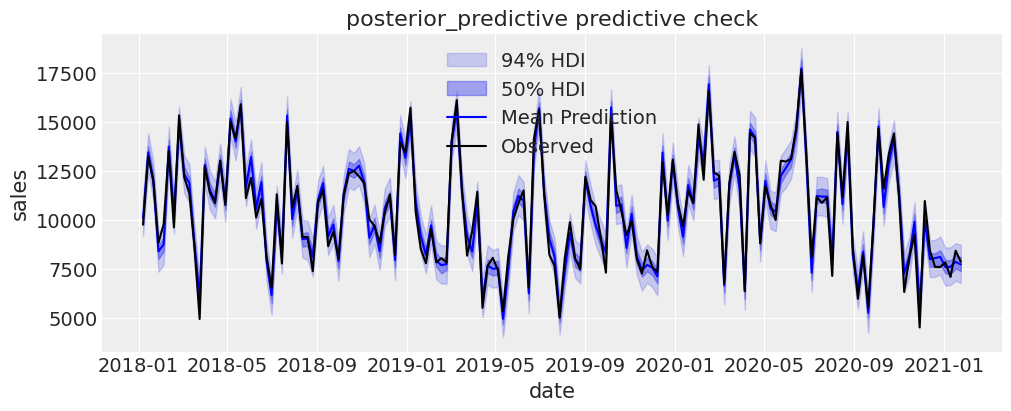

In [28]:
mmm.sample_posterior_predictive(X_train, extend_idata=True, combined=True)
fig = mmm.plot_posterior_predictive(original_scale=True)
fig.gca().set(xlabel="date", ylabel="sales")
plt.show()

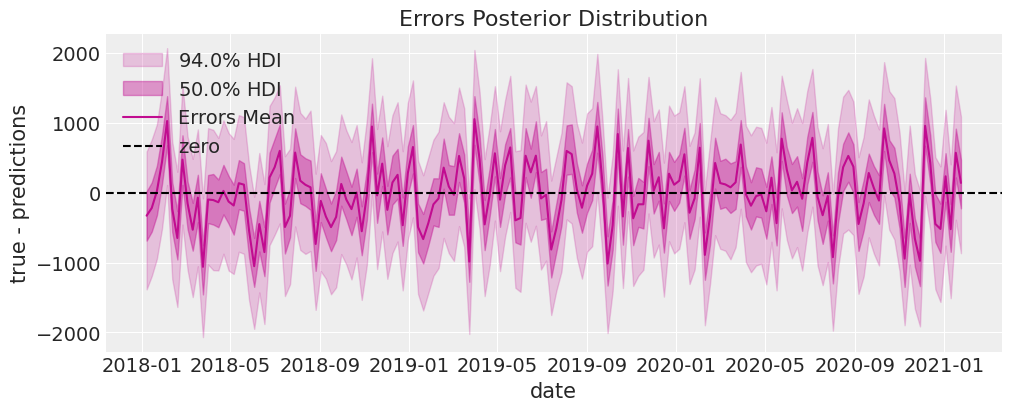

In [29]:
mmm.plot_errors(original_scale=True);

**Errors are mostly centered around zero**  
- This suggests that the **model does not have a strong bias** (it is not consistently **overestimating or underestimating** sales).  
- If the error is positive (above zero) → The model **underestimated sales** (predicted too low).  
- If the error is negative (below zero) → The model **overestimated sales** (predicted too high).  


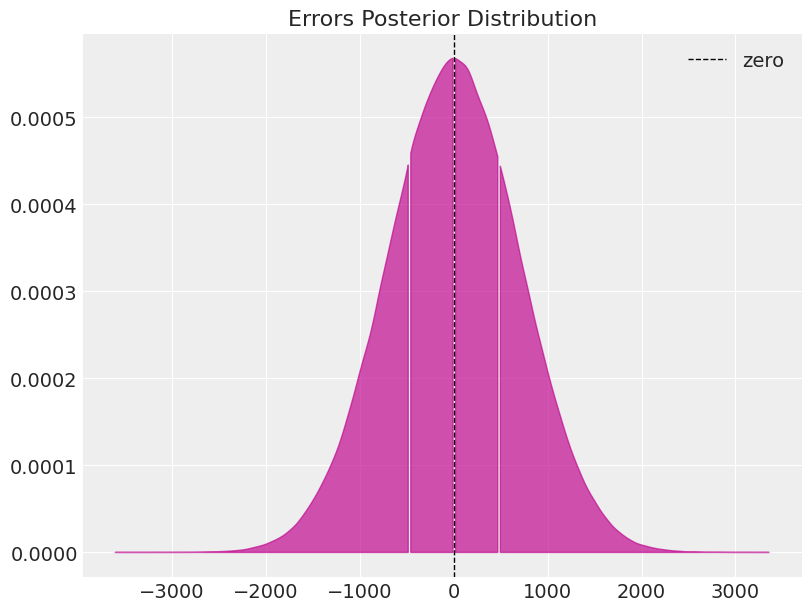

In [30]:
errors = mmm.get_errors(original_scale=True)

fig, ax = plt.subplots(figsize=(8, 6))
az.plot_dist(
    errors, quantiles=[0.25, 0.5, 0.75], color="C3", fill_kwargs={"alpha": 0.7}, ax=ax
)
ax.axvline(x=0, color="black", linestyle="--", linewidth=1, label="zero")
ax.legend()
ax.set(title="Errors Posterior Distribution")
plt.show()

### Channel deep dive

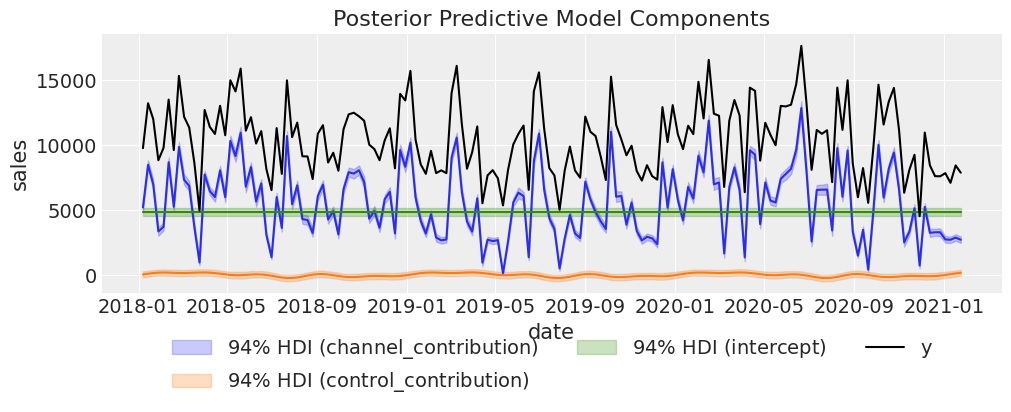

In [31]:
fig = mmm.plot_components_contributions(original_scale=True)
fig.gca().set(xlabel="date", ylabel="sales")
plt.show()

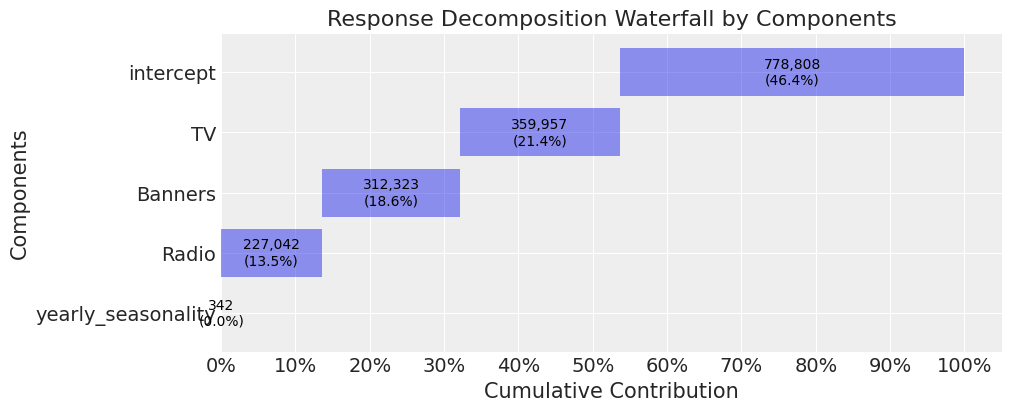

In [32]:
mmm.plot_waterfall_components_decomposition(figsize=(10, 4));

### channel wise Saturation Curves

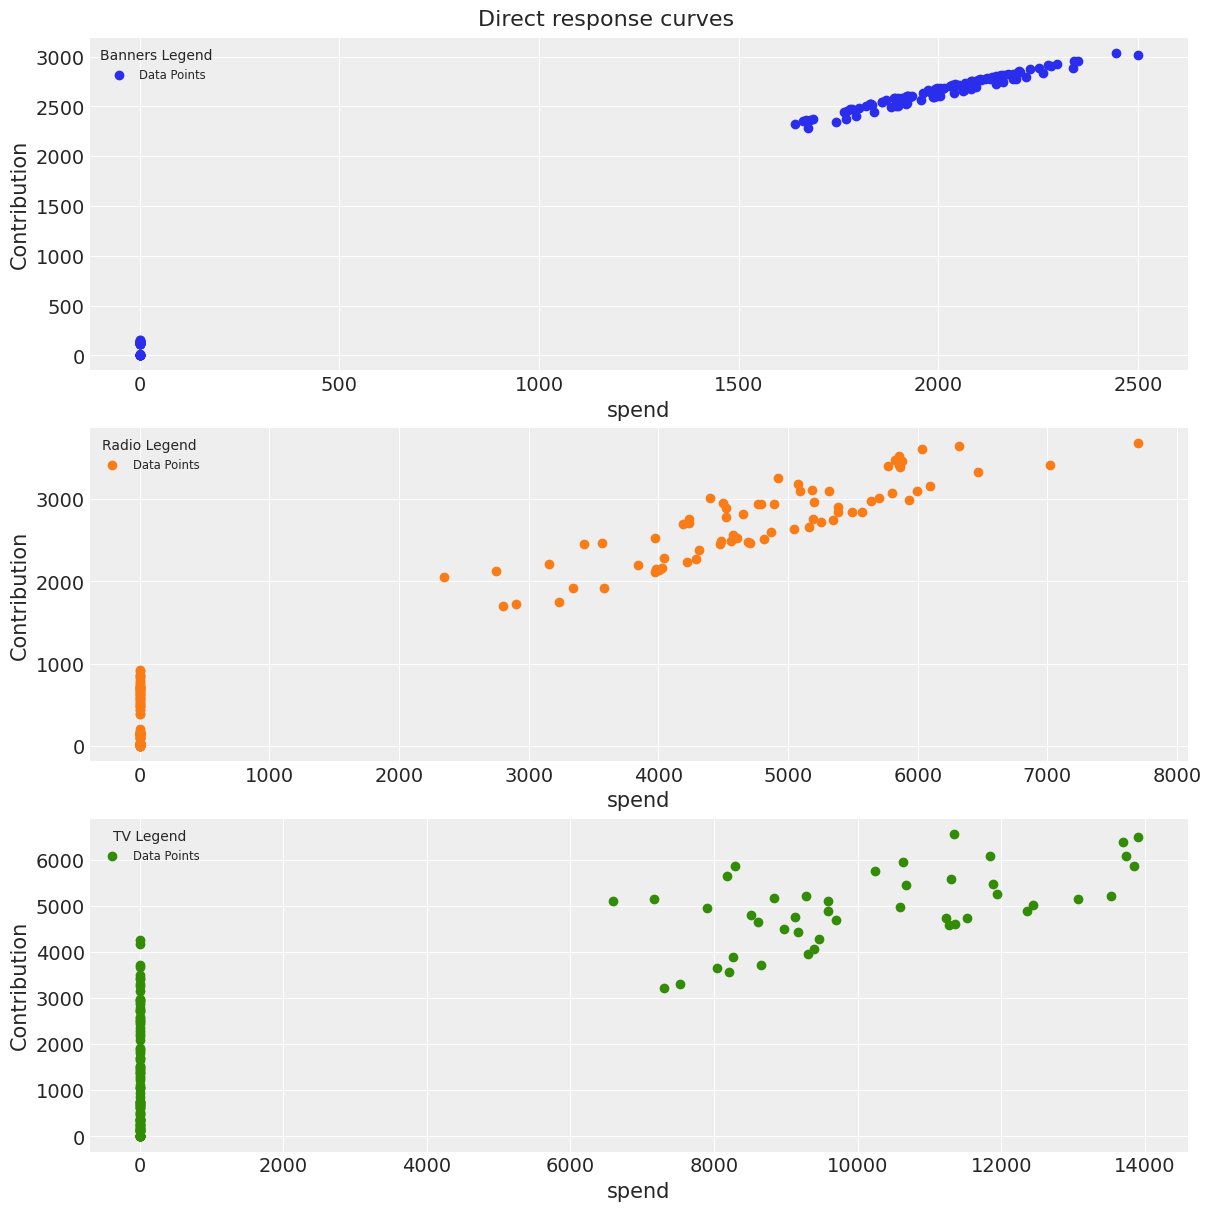

In [33]:
fig = mmm.plot_direct_contribution_curves()
[ax.set(xlabel="spend") for ax in fig.axes]
plt.show()

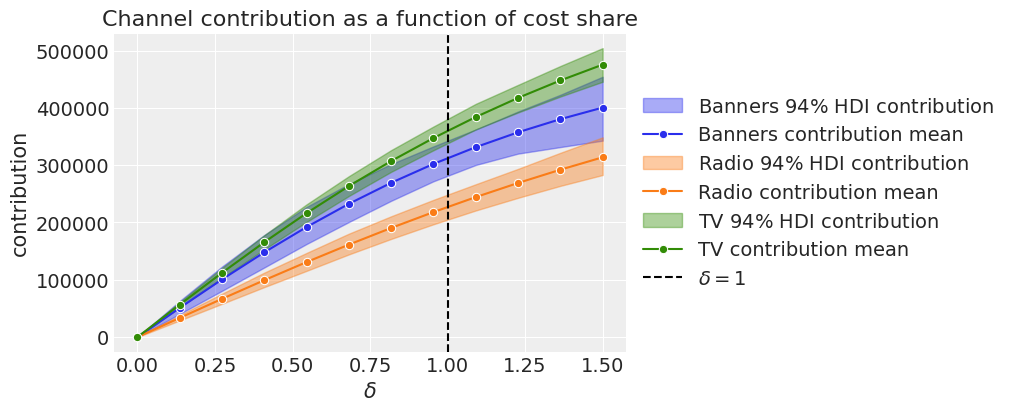

In [34]:
mmm.plot_channel_contributions_grid(start=0, stop=1.5, num=12, figsize=(10, 4));

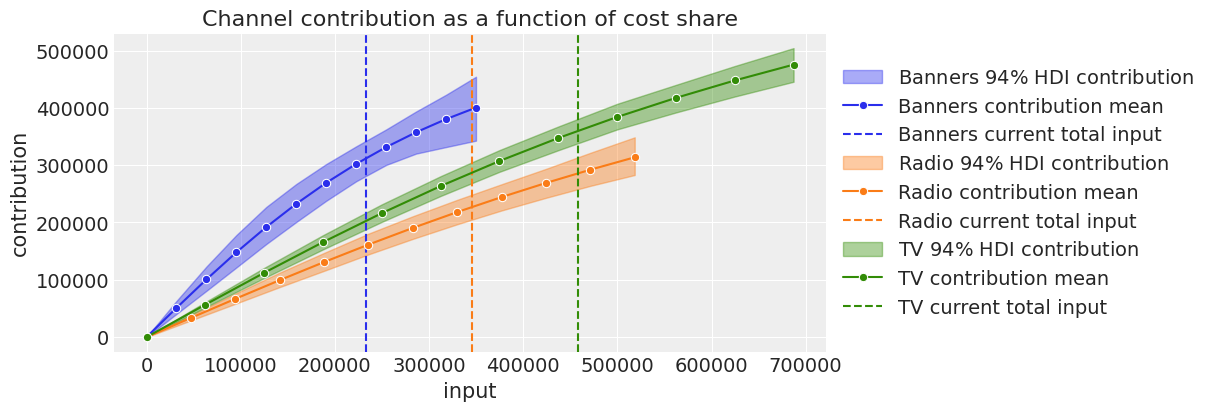

In [35]:
mmm.plot_channel_contributions_grid(
    start=0, stop=1.5, num=12, absolute_xrange=True, figsize=(12, 4)
);

### Return on Ads Spend (ROAS)

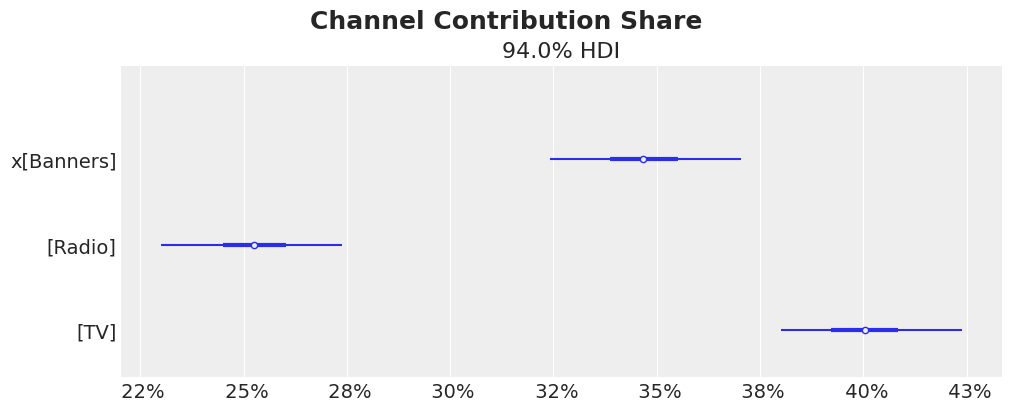

In [36]:
fig = mmm.plot_channel_contribution_share_hdi(figsize=(10, 4))
fig.suptitle("Channel Contribution Share", fontsize=18, fontweight="bold")
plt.show()

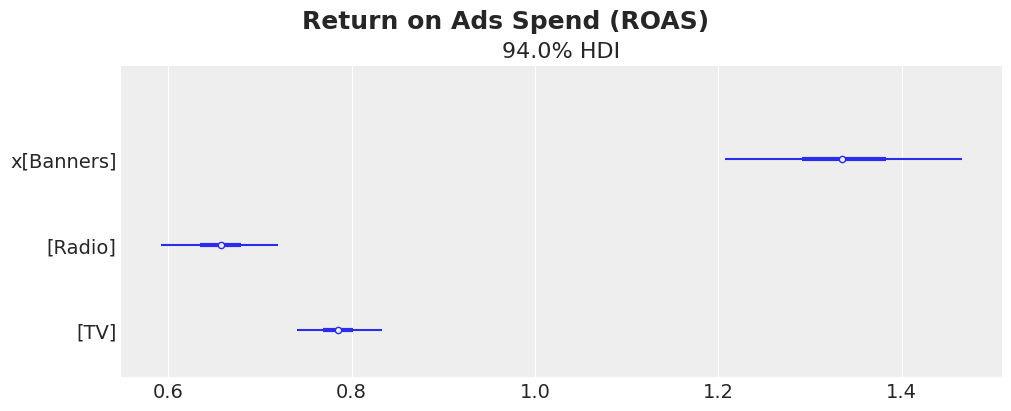

In [37]:
# Get the channel contributions on the original scale
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()

# Sum the contributions over the whole training period
spend_sum = X_train[channel_columns].sum().to_numpy()
spend_sum = spend_sum[
    np.newaxis, np.newaxis, :
]  # We need these extra dimensions to broadcast the spend sum to the shape of the contributions.

# Compute the ROAS as the ratio of the mean contribution and the spend for each channel
roas_samples = channel_contribution_original_scale.sum(dim="date") / spend_sum

# Plot the ROAS
fig, ax = plt.subplots(figsize=(10, 4))
az.plot_forest(roas_samples, combined=True, ax=ax)
fig.suptitle("Return on Ads Spend (ROAS)", fontsize=18, fontweight="bold")
plt.show()

**Banners Have the Highest ROAS (~1.3 - 1.4)**  
- This suggests **Banners are the most cost-effective channel**, generating **$1.30 - $1.40 per $1 spent**. 

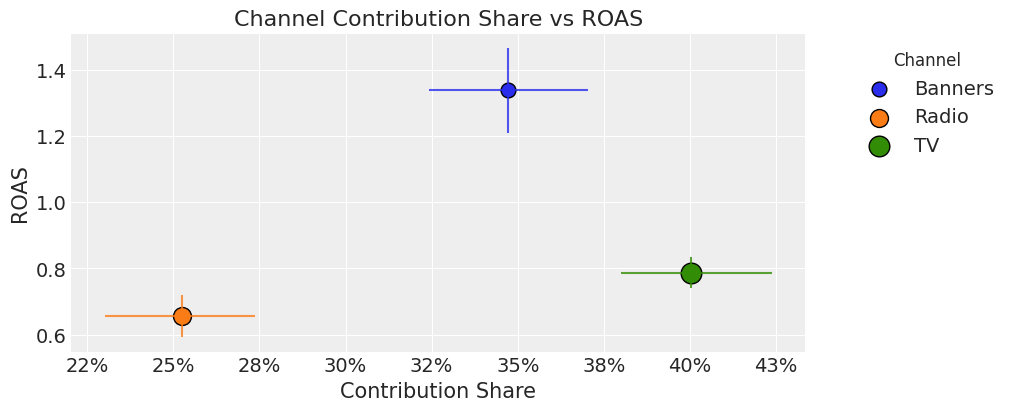

In [38]:
# Get the contribution share samples
share_samples = mmm.get_channel_contributions_share_samples()

fig, ax = plt.subplots(figsize=(10, 4))

for i, channel in enumerate(channel_columns):
    # Contribution share mean and hdi
    share_mean = share_samples.sel(channel=channel).mean().to_numpy()
    share_hdi = az.hdi(share_samples.sel(channel=channel))["x"].to_numpy()

    # ROAS mean and hdi
    roas_mean = roas_samples.sel(channel=channel).mean().to_numpy()
    roas_hdi = az.hdi(roas_samples.sel(channel=channel))["x"].to_numpy()

    # Plot the contribution share hdi
    ax.vlines(share_mean, roas_hdi[0], roas_hdi[1], color=f"C{i}", alpha=0.8)

    # Plot the ROAS hdi
    ax.hlines(roas_mean, share_hdi[0], share_hdi[1], color=f"C{i}", alpha=0.8)

    # Plot the means
    ax.scatter(
        share_mean,
        roas_mean,
        # Size of the scatter points is proportional to the spend share
        s=5 * (spend_shares[i] * 100),
        color=f"C{i}",
        edgecolor="black",
        label=channel,
    )
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

ax.legend(
    bbox_to_anchor=(1.05, 1), loc="upper left", title="Channel", title_fontsize=12
)
ax.set(
    title="Channel Contribution Share vs ROAS",
    xlabel="Contribution Share",
    ylabel="ROAS",
)
plt.show()

## Predictions on test data

In [39]:
y_pred_test = mmm.sample_posterior_predictive(
    X_test,
    include_last_observations=True,
    original_scale=True,
    var_names=["y", "channel_contributions"],
    extend_idata=False,
    progressbar=False,
    random_seed=rng,
)

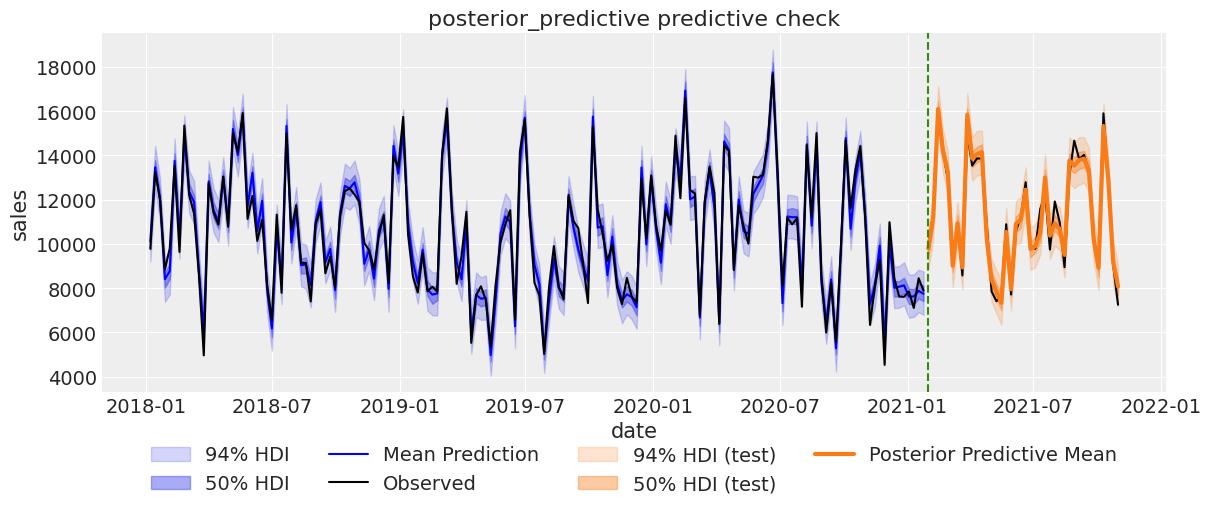

In [40]:
fig, ax = plt.subplots(figsize=(12, 5))
mmm.plot_posterior_predictive(original_scale=True, ax=ax)

test_hdi_94 = az.hdi(y_pred_test["y"].to_numpy().T, hdi_prob=0.94)
test_hdi_50 = az.hdi(y_pred_test["y"].to_numpy().T, hdi_prob=0.50)

ax.fill_between(
    X_test[date_column],
    test_hdi_94[:, 0],
    test_hdi_94[:, 1],
    color="C1",
    label=f"{0.94:.0%} HDI (test)",
    alpha=0.2,
)

ax.fill_between(
    X_test[date_column],
    test_hdi_50[:, 0],
    test_hdi_50[:, 1],
    color="C1",
    label=f"{0.50:.0%} HDI (test)",
    alpha=0.4,
)

ax.plot(X_test[date_column], y_test, color="black")
ax.plot(
    X_test[date_column],
    y_pred_test["y"].mean(dim="sample"),
    color="C1",
    linewidth=3,
    label="Posterior Predictive Mean",
)
ax.axvline(X_test[date_column].iloc[0], color="C2", linestyle="--")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(ylabel="sales")
plt.show()

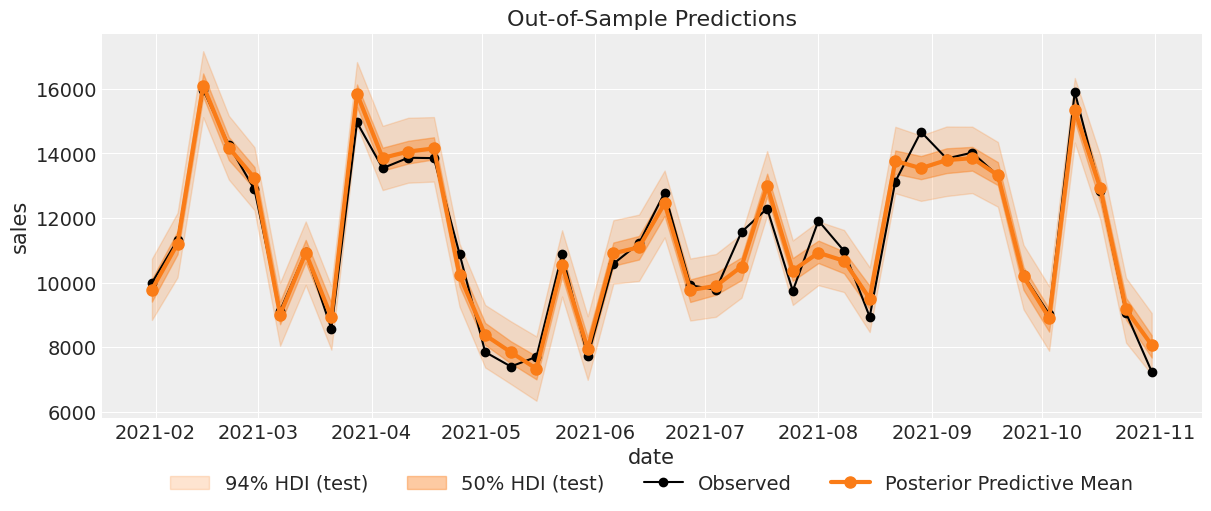

In [41]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.fill_between(
    X_test[date_column],
    test_hdi_94[:, 0],
    test_hdi_94[:, 1],
    color="C1",
    label=f"{0.94:.0%} HDI (test)",
    alpha=0.2,
)
ax.fill_between(
    X_test[date_column],
    test_hdi_50[:, 0],
    test_hdi_50[:, 1],
    color="C1",
    label=f"{0.50:.0%} HDI (test)",
    alpha=0.4,
)
ax.plot(X_test[date_column], y_test, marker="o", color="black", label="Observed")
ax.plot(
    X_test[date_column],
    y_pred_test["y"].mean(dim="sample"),
    marker="o",
    markersize=8,
    color="C1",
    linewidth=3,
    label="Posterior Predictive Mean",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(title="Out-of-Sample Predictions", xlabel="date", ylabel="sales")
plt.show();


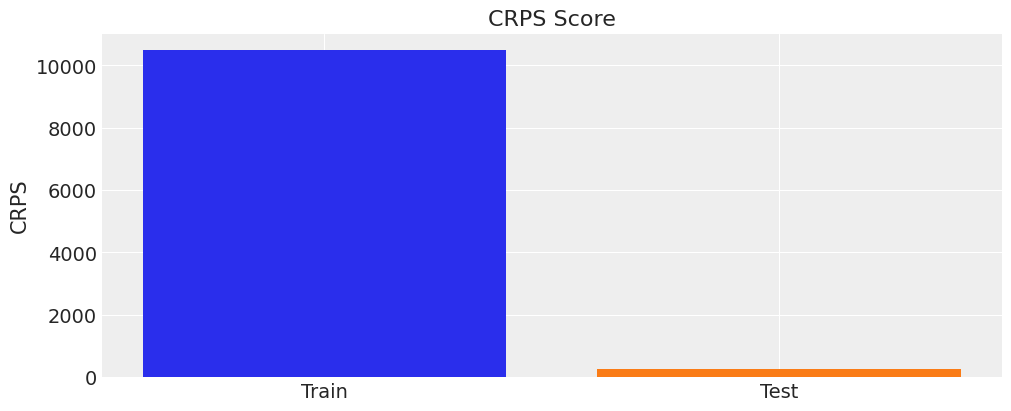

CRPS Train Score: 10491.7723
CRPS Test Score: 268.1908


In [42]:
# Compute Continuous Ranked Probability Score (CRPS) for the training dataset

crps_train = crps(
    y_true=y_train.to_numpy(),
    y_pred=az.extract(mmm.idata["posterior_predictive"], var_names=["y"]).T,
)

crps_test = crps(y_true=y_test.to_numpy(), y_pred=y_pred_test["y"].T)

fig, ax = plt.subplots()
ax.bar(["Train", "Test"], [crps_train, crps_test], color=["C0", "C1"])
ax.set(ylabel="CRPS", title="CRPS Score")
plt.show();

# Print CRPS values
print(f"CRPS Train Score: {crps_train:.4f}")
print(f"CRPS Test Score: {crps_test:.4f}")

**Training CRPS is very high**  
- This suggests **overfitting**, the model **fits training data too well but lacks flexibility**.  
- The model might be **memorizing noise rather than general trends**.  

**Test CRPS is significantly lower**  
- The model **performs much better on unseen data**, suggesting it **generalizes well**.  
- **Good Bayesian models** should have a **lower CRPS on test data than on train data**.  

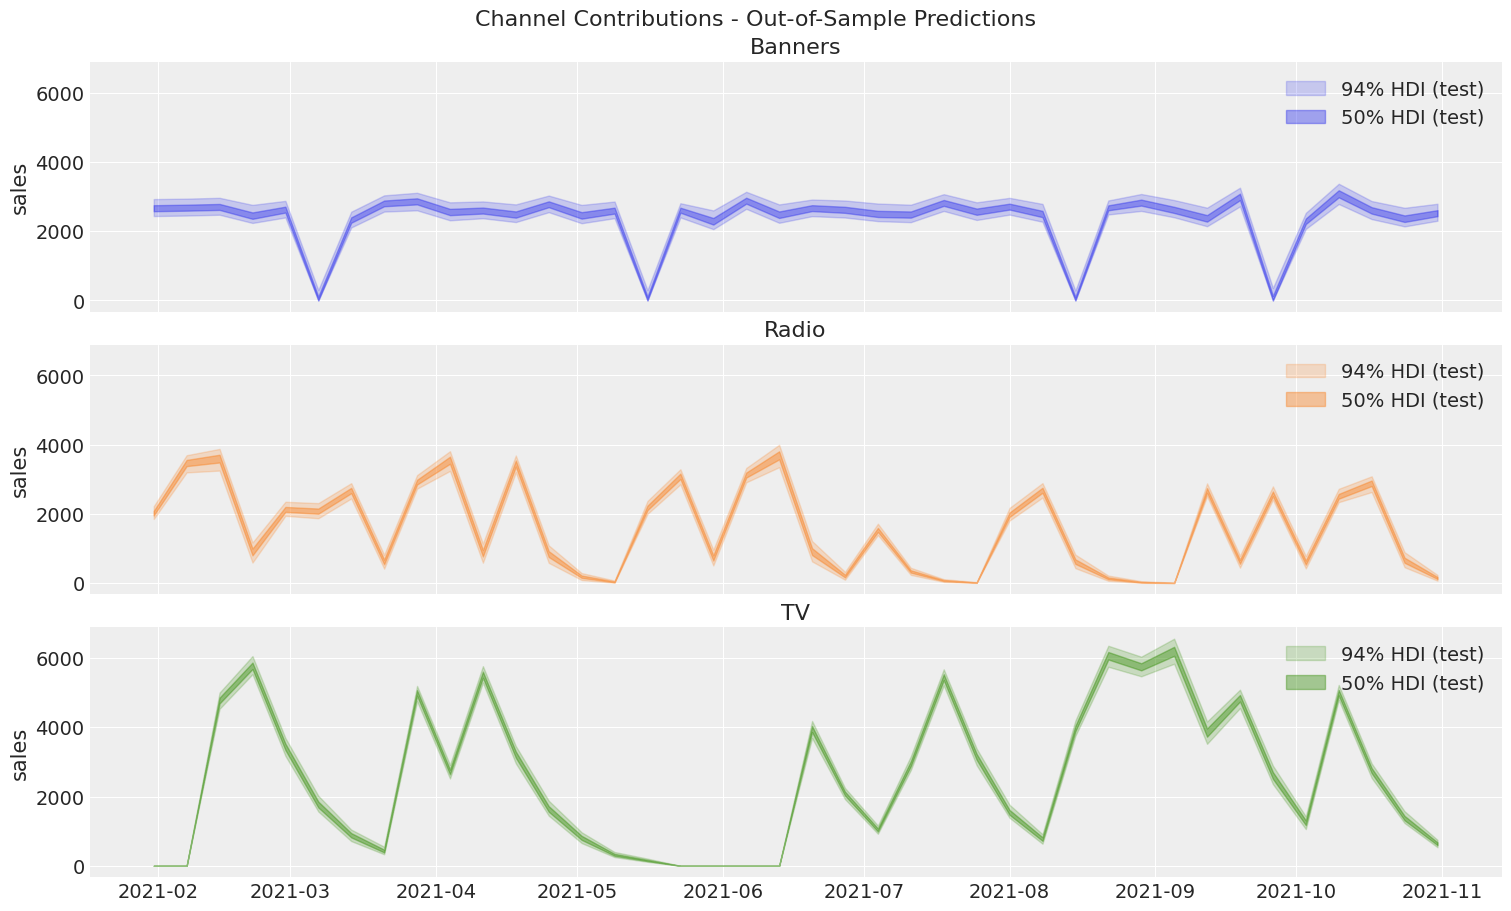

In [43]:
fig, axes = plt.subplots(
    nrows=len(channel_columns),
    ncols=1,
    figsize=(15, 3 * n_channels),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i, channel in enumerate(channel_columns):
    for j, hdi_prob in enumerate([0.94, 0.5]):
        ax = axes[i]
        az.plot_hdi(
            X_test[date_column],
            y_pred_test["channel_contributions"]
            .sel(channel=channel)
            .unstack()
            .transpose(..., "date"),
            hdi_prob=hdi_prob,
            color=f"C{i}",
            smooth=False,
            fill_kwargs={"alpha": 0.2 + 0.2 * j, "label": f"{hdi_prob:.0%} HDI (test)"},
            ax=ax,
        )
    ax.legend(loc="upper right")
    ax.set(title=channel, ylabel="sales")

fig.suptitle("Channel Contributions - Out-of-Sample Predictions", fontsize=16)
plt.show();

## 5. Future sales and spending optimation:

In [44]:
X_test[channel_columns].sum(axis=0)

Banners     70892.16
Radio       97086.44
TV         131150.06
dtype: float64

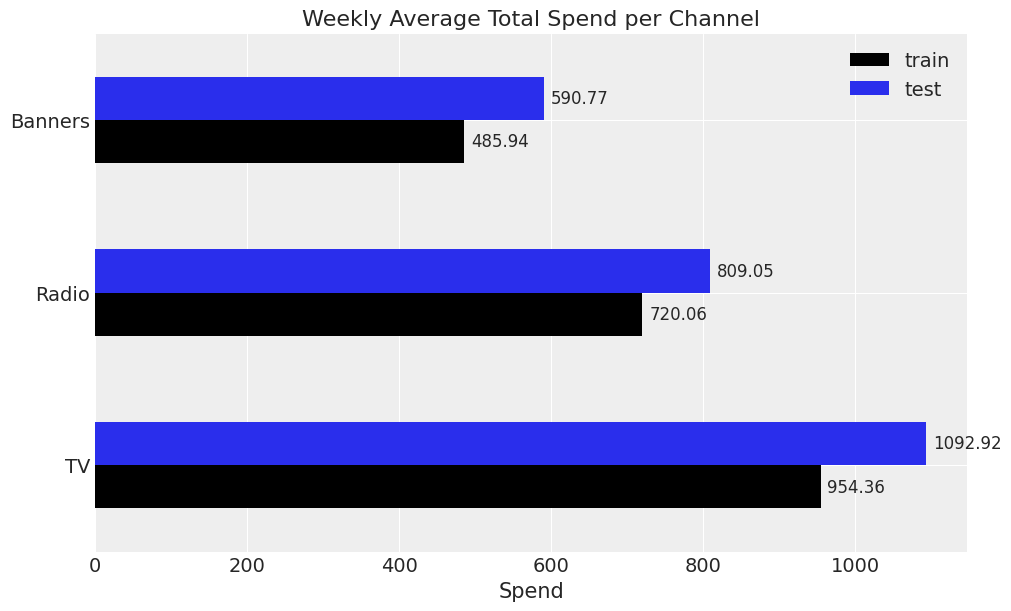

In [45]:
# Compute average spend per channel
average_spend_per_channel_train = X_train[channel_columns].sum(axis=0) / (
    X_train.shape[0] * len(channel_columns)
)
average_spend_per_channel_test = X_test[channel_columns].sum(axis=0) / (
    X_test.shape[0] * len(channel_columns)
)

# Create DataFrame for plotting
df_spend = average_spend_per_channel_train.to_frame(name="train").join(
    other=average_spend_per_channel_test.to_frame(name="test"),
    how="inner",
).sort_index(ascending=False)

# Plot bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = df_spend.plot.barh(color=["black", "C0"], ax=ax)

# Add value labels
for container in bars.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=12, padding=5, label_type="edge")

# Formatting
ax.set(title="Weekly Average Total Spend per Channel", xlabel="Spend")
plt.show()

In [46]:
num_periods = X_test[date_column].shape[0]

# Total budget for the test set per channel
all_budget_per_channel = X_test[channel_columns].sum(axis=0)

# Total budget for the test set
all_budget = all_budget_per_channel.sum()

# Weekly budget for each channel
# We are assuming we do not know the total budget allocation in advance
# so this would be the naive "uniform" allocation.
per_channel_weekly_budget = all_budget / (num_periods * len(channel_columns))

In [47]:
# Define a percentage change factor (±50% variation in spend)
percentage_change = 0.5

mean_spend_per_period_test = (
    X_test[channel_columns].sum(axis=0).div(num_periods * len(channel_columns))
)

# Define budget bounds per channel by allowing ±50% variation
budget_bounds= {
    key: [(1 - percentage_change) * value, (1 + percentage_change) * value]
    for key, value in (mean_spend_per_period_test).to_dict().items()
}

In [48]:
model_granularity = "weekly"
allocation_strategy, optimization_result = mmm.optimize_budget(
    budget=per_channel_weekly_budget,
    num_periods=num_periods,
    budget_bounds=budget_bounds,
    minimize_kwargs={
        "method": "SLSQP", # Use Sequential Least Squares Quadratic Programming (SLSQP) for constrained optimization
        "options": {"ftol": 1e-9, "maxiter": 5_000}, # Tolerance for optimization convergence is set very small for high precision
    },
)

response = mmm.sample_response_distribution(
    allocation_strategy=allocation_strategy,
    time_granularity=model_granularity,
    num_periods=num_periods,
    noise_level=0.05,
)

/home/mleshashi/MMM/mmm/lib/python3.10/site-packages/pymc_marketing/mmm/budget_optimizer.py:215: UserWarning: Using default equality constraint
  self.set_constraints(


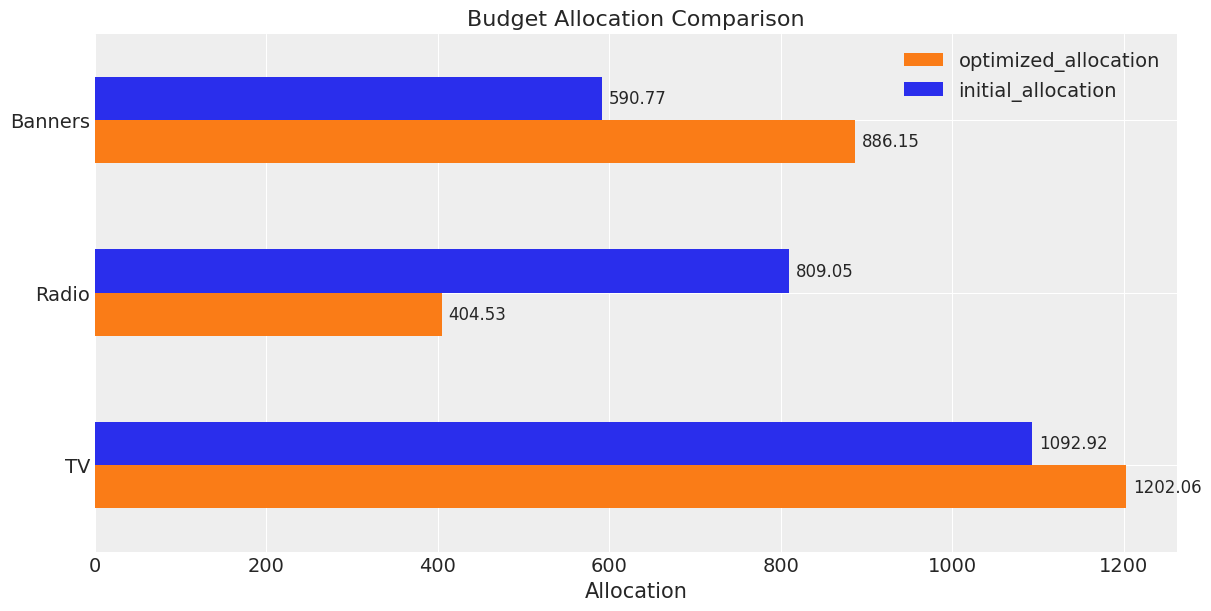

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))

# Preparing DataFrame for plotting
df_allocation = (
    pd.Series(allocation_strategy, index=mean_spend_per_period_test.index)
    .to_frame(name="optimized_allocation")
    .join(mean_spend_per_period_test.to_frame(name="initial_allocation"))
    .sort_index(ascending=False)
)

bars = df_allocation.plot.barh(color=["C1", "C0"], ax=ax)
# Add value labels inside the bars
for container in bars.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=12, padding=5, label_type="edge")

ax.set(title="Budget Allocation Comparison", xlabel="Allocation")
plt.show()

In [50]:
np.testing.assert_allclose(
    mean_spend_per_period_test.sum(), allocation_strategy.sum().item()
)

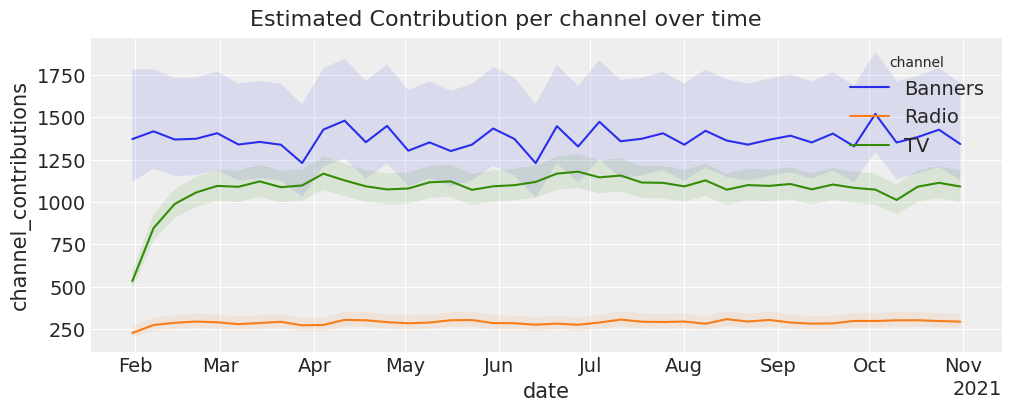

In [51]:
fig = mmm.plot_allocated_contribution_by_channel(samples=response)
fig.suptitle("Estimated Contribution per channel over time", fontsize=16);

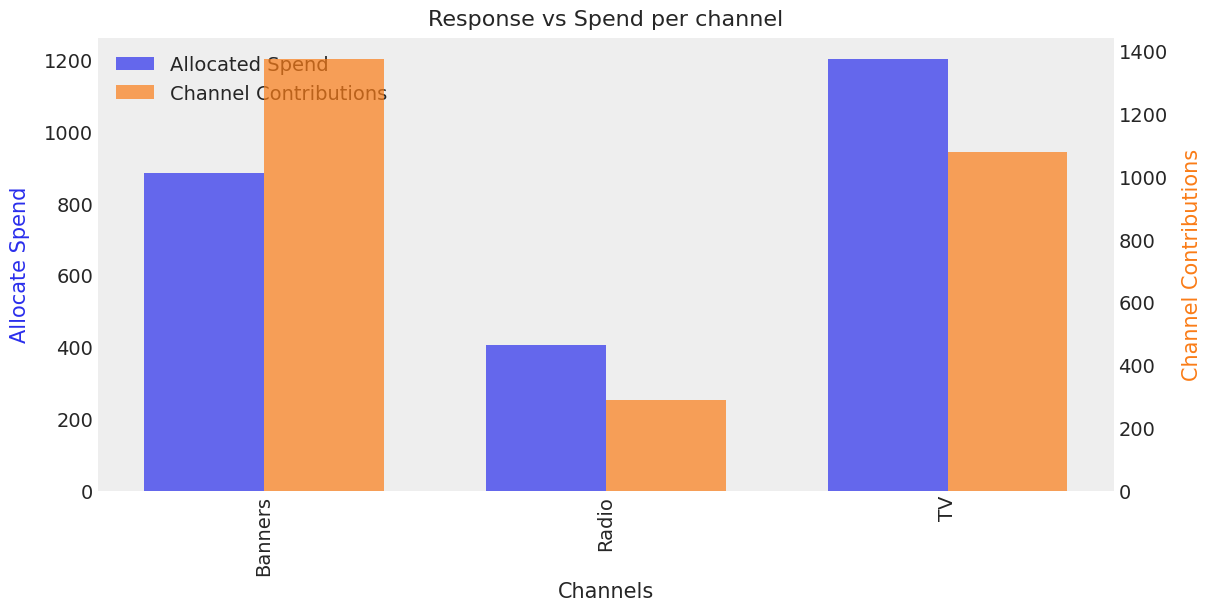

In [ ]:
fig, ax = mmm.plot_budget_allocation(samples=response, figsize=(12, 6))
fig.suptitle("Response vs Spend per channel", fontsize=16);

### Sales Comparison between optimized budget and naive budget

In [ ]:
# creating naive budget allocation dataset (X_actual_uniform) by replacing each channel's spend in X_test with its average test-period spend
# then generates posterior predictive sales and channel contribution samples using this naive allocation. 
X_actual_uniform = X_test.copy()

for channel in channel_columns:
    X_actual_uniform[channel] = mean_spend_per_period_test[channel]

# Generate Posterior Predictive Samples Using the Naive Budget
pred_test_uniform = mmm.sample_posterior_predictive(
    X_actual_uniform,
    include_last_observations=True,
    original_scale=True,
    var_names=["y", "channel_contributions"],
    extend_idata=False,
    progressbar=False,
    random_seed=rng,
)

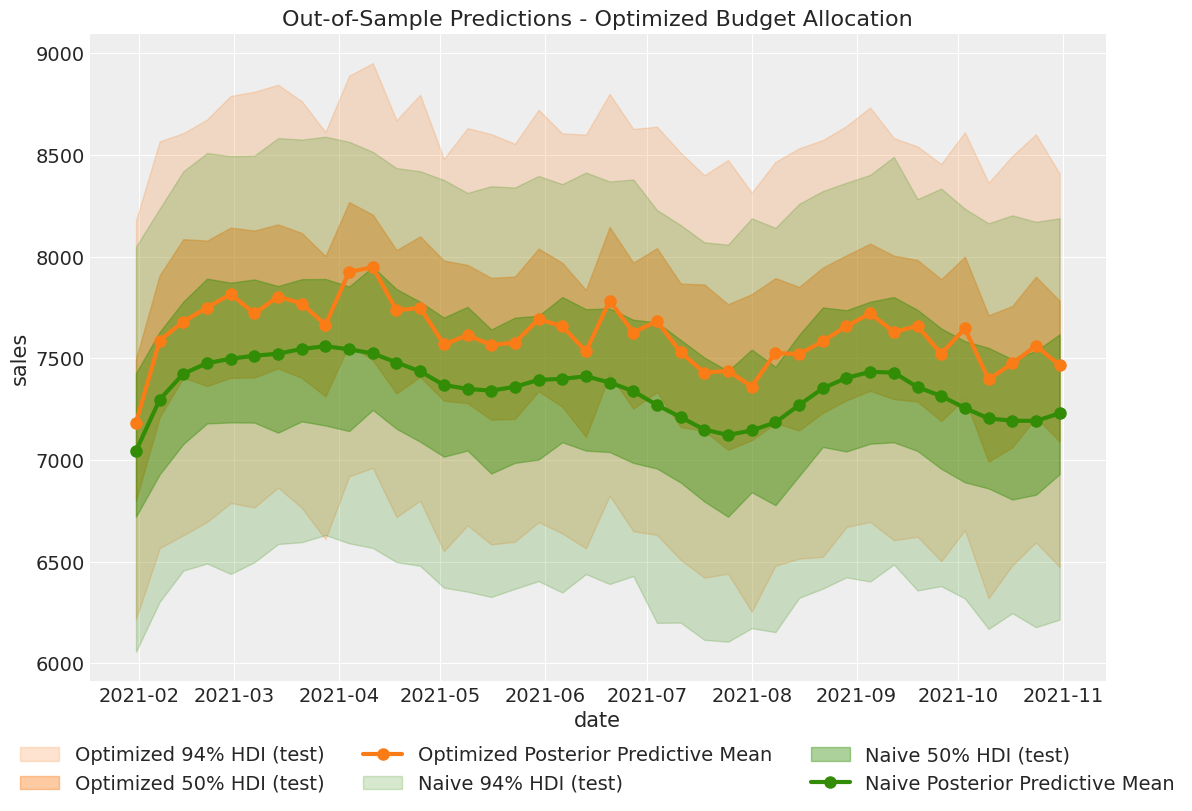

In [91]:
y_response_original_scale = apply_sklearn_transformer_across_dim(
    data=response["y"].unstack().transpose(..., "date"),
    func=mmm.get_target_transformer().inverse_transform,
    dim_name="date",
)

fig, ax = plt.subplots(figsize=(12, 8))

az.plot_hdi(
    X_test[date_column],
    y_response_original_scale,
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.2, "label": f"Optimized {0.94:.0%} HDI (test)"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    X_test[date_column],
    y_response_original_scale,
    hdi_prob=0.5,
    color="C1",
    fill_kwargs={"alpha": 0.4, "label": f"Optimized {0.50:.0%} HDI (test)"},
    smooth=False,
    ax=ax,
)
ax.plot(
    X_test[date_column],
    y_response_original_scale.mean(dim=("chain", "draw")),
    marker="o",
    markersize=8,
    color="C1",
    linewidth=3,
    label="Optimized Posterior Predictive Mean",
)

az.plot_hdi(
    X_actual_uniform[date_column],
    pred_test_uniform["y"].unstack().transpose(..., "date"),
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.2, "label": f"Naive {0.94:.0%} HDI (test)"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    X_actual_uniform[date_column],
    pred_test_uniform["y"].unstack().transpose(..., "date"),
    hdi_prob=0.5,
    color="C2",
    fill_kwargs={"alpha": 0.4, "label": f"Naive {0.50:.0%} HDI (test)"},
    smooth=False,
    ax=ax,
)
ax.plot(
    X_actual_uniform[date_column],
    pred_test_uniform["y"].unstack().transpose(..., "date").mean(dim=("chain", "draw")),
    marker="o",
    markersize=8,
    color="C2",
    linewidth=3,
    label="Naive Posterior Predictive Mean",
)

ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.20), ncol=3)

ax.set(
    title="Out-of-Sample Predictions - Optimized Budget Allocation",
    xlabel="date",
    ylabel="sales",
);

- The orange line (optimized posterior predictive mean) is consistently above the green line (naive posterior predictive mean).
- This means the optimized budget allocation strategy results in higher expected sales compared to the naive allocation.